In [1]:
import sys
sys.path.append("..")

from utils.config import CONFIG
from utils.lmdb import LMDBImageReader, chexpert_indexer
from pathlib import Path
from utils.img import plot_imgs
from random import sample
import pickle
from io import BytesIO
from typing import Dict, List, Optional, Tuple, Union, Any

import cusignal as cs
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm
from utils.config import CONFIG
from utils.img import center_crop
from utils.lmdb import LMDBImageWriter, covid_ct_indexer_lung

In [2]:
infos = pickle.load(open("/home/peter/data/covid_ct/train_infos.pkl", "rb"))

In [15]:
def denoise(img: np.ndarray) -> np.ndarray:
    kernel = np.ones((3, 3), np.uint8)

    for _ in range(3):
        img = cv.erode(img, kernel, iterations=1)
        img = cv.dilate(img, kernel, iterations=1)
    return img

def renoise(img: np.ndarray) -> np.ndarray:
    kernel = np.ones((3, 3), np.uint8)

    for _ in range(3):
        img = cv.dilate(img, kernel, iterations=1)
        img = cv.erode(img, kernel, iterations=1)
    return img

def get_img(paths: List[str]):
    # Read image using sitk
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(paths)
    image: sitk.Image = reader.Execute()

    # Resample image to new pixel spacing
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    new_spacing = [1, 1, 1]
    new_size = [
        int(i * j / k) for i, j, k in zip(original_size, original_spacing, new_spacing)
    ]
    image = sitk.Resample(
        image1=image,
        size=new_size,
        transform=sitk.Transform(),
        interpolator=sitk.sitkLinear,
        outputOrigin=image.GetOrigin(),
        outputSpacing=new_spacing,
        outputDirection=image.GetDirection(),
        defaultPixelValue=0,
        outputPixelType=image.GetPixelID(),
    )
    np_img = sitk.GetArrayFromImage(image)
    np_img = np.where(np_img < np.percentile(np_img, 95), 0, 255).astype(np.uint8)
    imgs = [denoise(img) for img in np_img]

    np_thres = cv.resize(center_crop(np.mean(imgs, axis=1).astype(np.uint8)), (256, 256))
    thres: Any = cv.threshold(
        cv.equalizeHist(np_thres), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
    )[1]
    return renoise(thres)


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


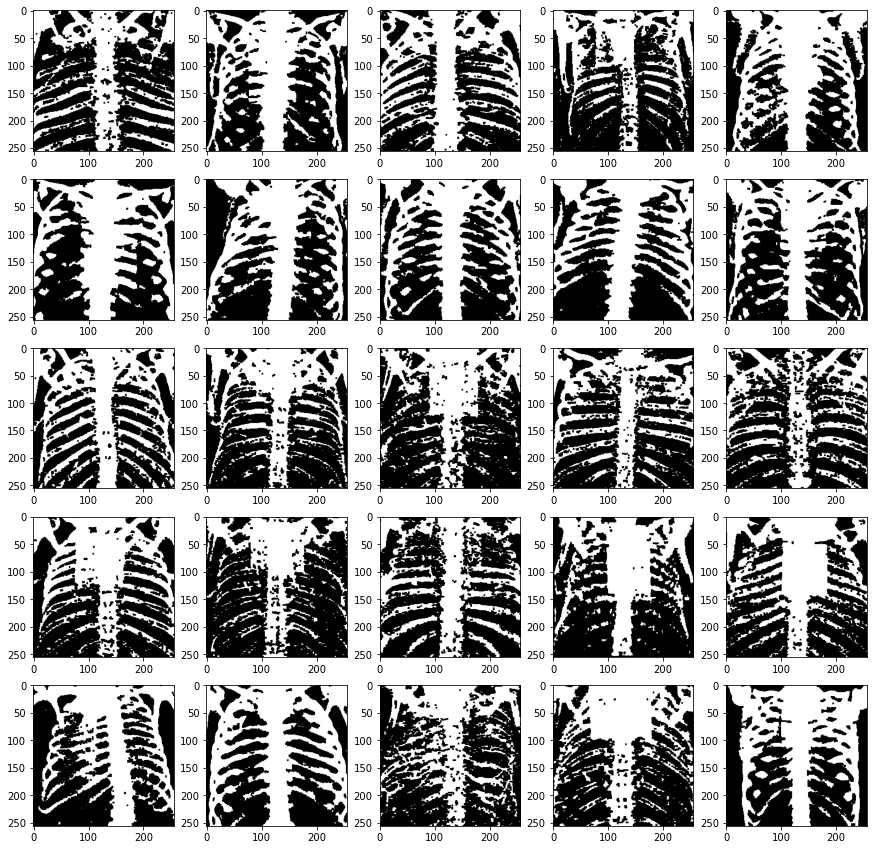

In [17]:
n = 5
rand_infos = sample(infos, n ** 2)
fig, axs = plt.subplots(n, n, figsize=(15, 15))
for i in tqdm(range(n**2)):
    x, y = divmod(i, n)
    img = get_img(rand_infos[i]["lung"])
    axs[x, y].imshow(img, cmap="gray")